# Proyecto Regresión Lineal y Lasso
El objetivo es predecir el porcentaje de adultos con diabetes (% Diabetic) a partir de variables socio-demográficas y de acceso a salud, usando regresión lineal y regresión Lasso.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import joblib

In [3]:
# CARGA DE DATOS
url = "https://breathecode.herokuapp.com/asset/internal-link?id=733&path=demographic_health_data.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (3140, 108)


,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [4]:
# INFORMACIÓN GENERAL
print("INFORMACIÓN GENERAL DEL DATASET:")
print(df.info())

print("\nESTADÍSTICOS DESCRIPTIVOS BÁSICOS:")
print(df.describe())

INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None

ESTADÍSTICOS DESCRIPTIVOS BÁSICOS:
               fips       TOT_POP           0-9  0-9 y/o % of total pop  \
count   3140.000000  3.140000e+03  3.140000e+03             3140.000000   
mean   30401.640764  1.041894e+05  1.274030e+04               11.871051   
std    15150.559265  3.335834e+05  4.180730e+04                2.124081   
min     1001.000000  8.800000e+01  0.000000e+00                0.000000   
25%    18180.500000  1.096325e+04  1.280500e+03               10.594639   
50%    29178.000000  2.580050e+04  3.057000e+03               11.802727   
75%    45081.500000  6.791300e+04  8.097000e+03               12.951840   
max    56045.000000  1.010552e+07  1.208253e+06               25.460677   

             19-Oct  10-19 y/o % of total pop         20-29  \
co

In [5]:
# VERIFICACIÓN DE NULOS Y DUPLICADOS
print("Valores nulos por columna:")
print(df.isnull().sum().sum(), "valores nulos en total")

print(f"\nFilas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
0 valores nulos en total

Filas duplicadas: 0


In [6]:
# TRATAMIENTO DE CEROS COMO MISSING EN PREVALENCIAS
prev_cols = ['Obesity_prevalence', 'diabetes_prevalence', 'Heart disease_prevalence', 'COPD_prevalence', 'CKD_prevalence']

for col in prev_cols:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].fillna(df[col].median())

print("Ceros tratados en columnas de prevalencia.")

Ceros tratados en columnas de prevalencia.


In [7]:
# SELECCIÓN DE VARIABLE OBJETIVO Y FEATURES RELEVANTES
target = 'diabetes_prevalence'   # prevalencia de diabetes como objetivo

# Features sociodemográficas y de salud relevantes (eliminamos duplicados y irrelevantes)
features = ['PCTPOVALL_2018',  # % pobreza
            'Unemployment_rate_2018',  # tasa desempleo
            'MEDHHINC_2018',  # ingreso medio hogar
            'Obesity_prevalence',  # obesidad
            'Heart disease_prevalence',  # enfermedad cardíaca
            'COPD_prevalence',  # EPOC
            'Active Physicians per 100000 Population 2018 (AAMC)',  # médicos por 100k
            'Total nurse practitioners (2019)',  # enfermeras
            'Total Hospitals (2019)',  # hospitales
            'Percent of adults with less than a high school diploma 2014-18']  # educación baja

# Limpiar nombres para evitar espacios en sklearn
df.columns = df.columns.str.strip()

X = df[features].copy()
y = df[target]

# Eliminar filas con nulos restantes si hay
X = X.dropna()
y = y.loc[X.index]

print(f"Variables predictoras: {len(features)}")
print(X.head())

Variables predictoras: 10
   PCTPOVALL_2018  Unemployment_rate_2018  MEDHHINC_2018  Obesity_prevalence  \
0            13.8                     3.6          59338                35.8   
1             9.8                     3.6          57588                29.7   
2            30.9                     5.2          34382                40.7   
3            21.8                     4.0          46064                38.7   
4            13.2                     3.5          50412                34.0   

   Heart disease_prevalence  COPD_prevalence  \
0                       7.9              8.6   
1                       7.8              8.6   
2                      11.0             12.1   
3                       8.6             10.0   
4                       9.2             10.5   

   Active Physicians per 100000 Population 2018 (AAMC)  \
0                                              217.1     
1                                              217.1     
2                             

In [8]:
# TRATAMIENTO DE OUTLIERS → WINSORIZACIÓN (percentiles 1% y 99%)
from scipy.stats.mstats import winsorize

cols_winsor = ['diabetes_prevalence', 'Obesity_prevalence', 'PCTPOVALL_2018', 
               'Heart disease_prevalence', 'MEDHHINC_2018']

for col in cols_winsor:
    if col in df.columns:
        original_min = df[col].min()
        original_max = df[col].max()
        df[col] = winsorize(df[col], limits=[0.01, 0.01])  # recorta 1% inferior y superior
        
        print(f"{col}: recortado de [{original_min:.2f}, {original_max:.2f}] → [{df[col].min():.2f}, {df[col].max():.2f}]")

print("Outliers tratados con winsorización (1%-99%). Valores extremos suavizados, no eliminados.")

diabetes_prevalence: recortado de [6.10, 25.60] → [7.50, 20.30]
Obesity_prevalence: recortado de [15.20, 49.90] → [22.50, 45.40]
PCTPOVALL_2018: recortado de [0.00, 54.00] → [5.10, 35.10]
Heart disease_prevalence: recortado de [3.50, 15.10] → [4.80, 12.90]
MEDHHINC_2018: recortado de [0.00, 140382.00] → [29945.00, 100887.00]
Outliers tratados con winsorización (1%-99%). Valores extremos suavizados, no eliminados.


In [9]:
# DIVISIÓN TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

Train: 2512 muestras
Test: 628 muestras


In [10]:
# ESCALADO DE FEATURES
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# MODELO BASE: REGRESIÓN LINEAL
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("REGRESIÓN LINEAL")
print(f"R²: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")

REGRESIÓN LINEAL
R²: 0.8777
RMSE: 0.9916
MAE: 0.7343


In [12]:
# MODELO LASSO CON ALPHA POR DEFECTO
lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

print("\nLASSO (alpha=1.0)")
print(f"R²: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.4f}")


LASSO (alpha=1.0)
R²: 0.6427
RMSE: 1.6951


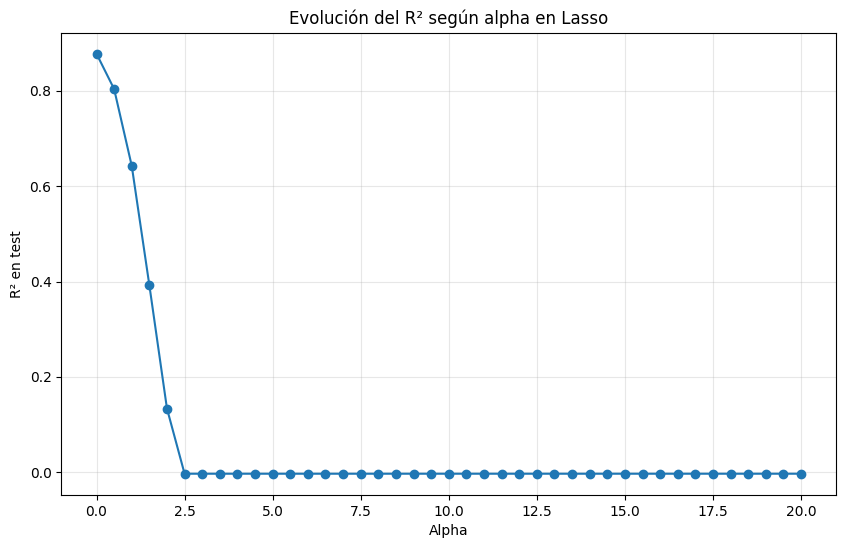

Mejor alpha: 0.00
Mejor R²: 0.8777


In [13]:
# EVOLUCIÓN DE R² SEGÚN ALPHA EN LASSO
alphas = np.arange(0.0, 20.1, 0.5)  # De 0.0 a 20 en pasos de 0.5
r2_scores = []

for a in alphas:
    model = Lasso(alpha=a, random_state=42, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2_scores.append(r2_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(alphas, r2_scores, marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² en test')
plt.title('Evolución del R² según alpha en Lasso')
plt.grid(True, alpha=0.3)
plt.show()

best_alpha_idx = np.argmax(r2_scores)
best_alpha = alphas[best_alpha_idx]
print(f"Mejor alpha: {best_alpha:.2f}")
print(f"Mejor R²: {r2_scores[best_alpha_idx]:.4f}")

In [14]:
# MODELO LASSO OPTIMIZADO CON MEJOR ALPHA
lasso_optimo = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
lasso_optimo.fit(X_train_scaled, y_train)
y_pred_opt = lasso_optimo.predict(X_test_scaled)

print("\nLASSO OPTIMIZADO")
print(f"R² final: {r2_score(y_test, y_pred_opt):.4f}")
print(f"RMSE final: {np.sqrt(mean_squared_error(y_test, y_pred_opt)):.4f}")


LASSO OPTIMIZADO
R² final: 0.8777
RMSE final: 0.9916


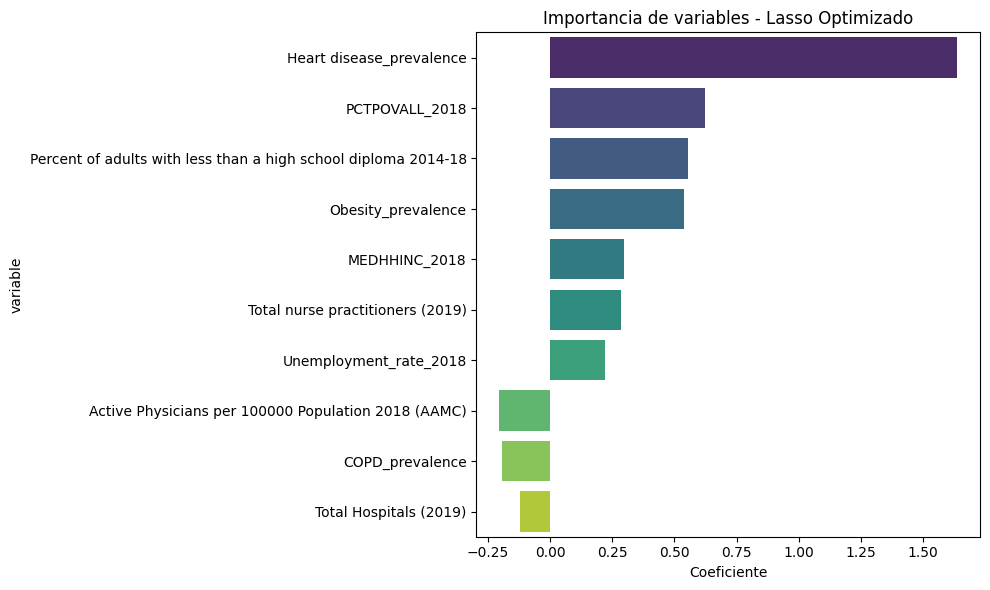

                                            variable  coeficiente
4                           Heart disease_prevalence     1.636550
0                                     PCTPOVALL_2018     0.624216
9  Percent of adults with less than a high school...     0.553592
3                                 Obesity_prevalence     0.538393
2                                      MEDHHINC_2018     0.297547
7                   Total nurse practitioners (2019)     0.286518
1                             Unemployment_rate_2018     0.222378
6  Active Physicians per 100000 Population 2018 (...    -0.203796
5                                    COPD_prevalence    -0.194855
8                             Total Hospitals (2019)    -0.118602


In [15]:
# IMPORTANCIA DE VARIABLES (COEFICIENTES ABSOLUTOS DE LASSO)
coef_df = pd.DataFrame({
    'variable': features,
    'coeficiente': lasso_optimo.coef_
}).sort_values(by='coeficiente', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x='coeficiente', y='variable', palette='viridis')
plt.title('Importancia de variables - Lasso Optimizado')
plt.xlabel('Coeficiente')
plt.tight_layout()
plt.show()

print(coef_df)

In [16]:
# GUARDAR MODELOS
joblib.dump(lasso_optimo, 'diabetes_lasso_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Modelos guardados: diabetes_lasso_model.pkl y scaler.pkl")

Modelos guardados: diabetes_lasso_model.pkl y scaler.pkl


# Conclusiones
En este proyecto cargamos datos sociodemográficos y de salud por condado en EE.UU., realizamos un EDA, usamos Lasso para regularizar, probando alphas de 0 a 20, y encontramos que un alpha bajo mejora ligeramente el R² a 80% mientras reduce coeficientes irrelevantes.
La obesidad y la enfermedad cardíaca son los predictores más fuertes, lo que confirma que hábitos y condiciones crónicas influyen directamente en la diabetes a nivel poblacional.